# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

# from google.colab import drive
# from os import chdir

# drive.mount('/content/drive')
# project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
# chdir(project_path)

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\n\nsetInterval(ConnectButton,60000);\n'

In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

D:\Gdrive\My Drive\Gproject\MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
dataset = pd.read_csv(load_name)

dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)
positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:      ", len(dataset.protein.unique()))
print("total number of samples:       ", len(dataset))
print("total number of positive sites:", len(positive))
print("total number of negative sites:", len(negative))

total number of proteins:       272
total number of samples:        41264
total number of positive sites: 521
total number of negative sites: 40743


## parameter settings

In [4]:
from src.Data import xy_variables, df_to_dummy, stratified_split, up_sampling
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 10

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [6]:
model_name = 'mlp_window'

x_cts   = variables.x_cts_window
x_cat   = variables.x_cat_window
y_label = variables.y_label

print(f"{len(x_cts)} x_cts: {x_cts}")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

2 x_cts: ['Proline', 'flexibility']
12 x_cat: ['SEQ', 'nS/nT', 'nAli', 'nPos', 'phi_psi', 'SS', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5']
1 y_label: ['positivity']
dummy x shape: (41264, 87)
dummy y shape: (41264, 1)


{0: 'Proline',
 1: 'flexibility',
 2: 'SEQ_S',
 3: 'SEQ_T',
 4: 'nS/nT_1',
 5: 'nS/nT_2',
 6: 'nS/nT_3',
 7: 'nS/nT_4',
 8: 'nS/nT_5',
 9: 'nS/nT_6',
 10: 'nS/nT_7',
 11: 'nS/nT_8',
 12: 'nS/nT_9',
 13: 'nS/nT_10',
 14: 'nS/nT_11',
 15: 'nS/nT_12',
 16: 'nS/nT_13',
 17: 'nS/nT_14',
 18: 'nS/nT_15',
 19: 'nS/nT_16',
 20: 'nS/nT_17',
 21: 'nS/nT_18',
 22: 'nS/nT_19',
 23: 'nS/nT_20',
 24: 'nS/nT_21',
 25: 'nAli_0',
 26: 'nAli_1',
 27: 'nAli_2',
 28: 'nAli_3',
 29: 'nPos_0',
 30: 'nPos_1',
 31: 'nPos_2',
 32: 'nPos_3',
 33: 'phi_psi_alpha',
 34: 'phi_psi_beta',
 35: 'phi_psi_other',
 36: 'SS_C',
 37: 'SS_E',
 38: 'SS_H',
 39: 'side_-1_None',
 40: 'side_-1_cycle',
 41: 'side_-1_gly',
 42: 'side_-1_long',
 43: 'side_-1_normal',
 44: 'side_-1_pro',
 45: 'side_-1_small',
 46: 'side_-1_very_small',
 47: 'side_1_None',
 48: 'side_1_cycle',
 49: 'side_1_gly',
 50: 'side_1_long',
 51: 'side_1_normal',
 52: 'side_1_pro',
 53: 'side_1_small',
 54: 'side_1_very_small',
 55: 'side_2_None',
 56: 'side

## cross validation

In [7]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_size, save_path=save_path)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been saved to ./h5/mlp_window_5_100_cv_1of10.h5

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been saved to ./h5/mlp_window_5_100_cv_2of10.h5

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.08719646799117
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been saved to ./h5/mlp_window_5_100_cv_3of10.h5

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,82,8.483,0.598552,0.594753,0.599058,67.55,2.08,53.85,4.01
1,5,100,56,6.533,0.599897,0.599940,0.601510,67.14,1.95,50.96,3.76
2,5,100,30,4.613,0.601748,0.595688,0.592353,67.78,2.06,52.88,3.97
3,5,100,72,7.582,0.601994,0.594727,0.611098,66.39,2.22,59.62,4.28
4,5,100,69,6.821,0.608740,0.607585,0.611713,66.09,2.20,59.62,4.24
5,5,100,28,4.330,0.600457,0.599678,0.599262,67.95,2.22,56.73,4.27
6,5,100,106,9.998,0.609421,0.611717,0.592766,67.95,2.61,67.31,5.03
7,5,100,38,5.100,0.608401,0.608772,0.608248,66.42,2.43,65.38,4.68
8,5,100,62,6.948,0.609307,0.606779,0.609665,66.41,2.43,65.38,4.68
9,5,100,35,4.870,0.611012,0.615598,0.623559,65.42,2.62,73.08,5.06



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_1of10.h5


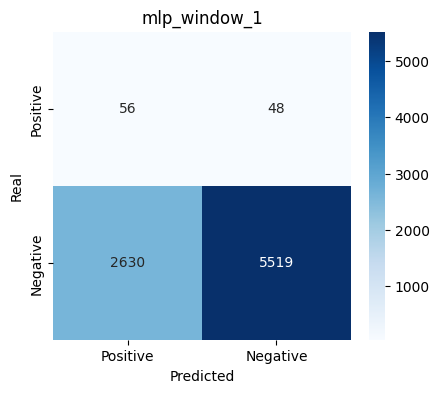

accuracy  : 67.55
precision : [99.14  2.08]
recall    : [67.73 53.85]
f1_score  : [80.48  4.01]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_2of10.h5


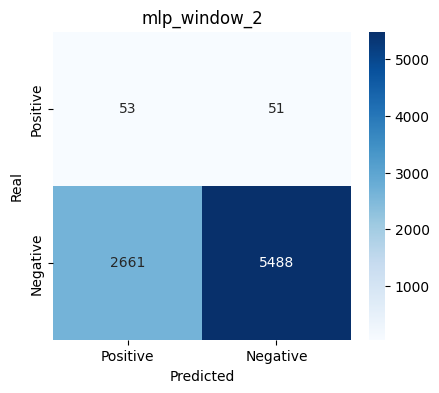

accuracy  : 67.14
precision : [99.08  1.95]
recall    : [67.35 50.96]
f1_score  : [80.19  3.76]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.08719646799117
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_3of10.h5


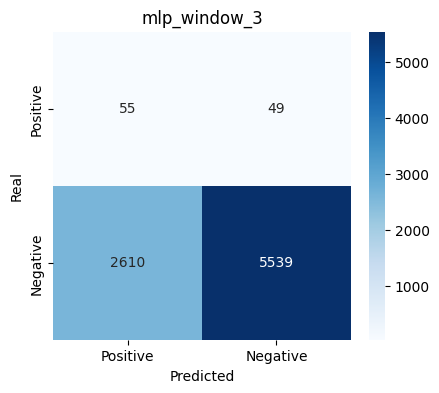

accuracy  : 67.78
precision : [99.12  2.06]
recall    : [67.97 52.88]
f1_score  : [80.64  3.97]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_4of10.h5


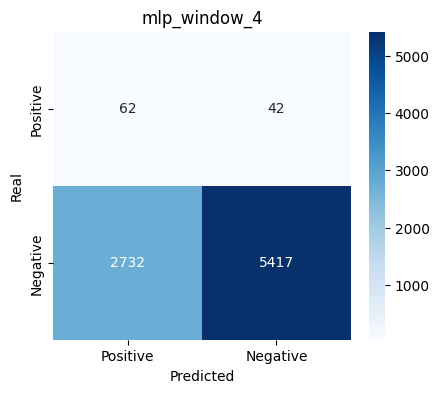

accuracy  : 66.39
precision : [99.23  2.22]
recall    : [66.47 59.62]
f1_score  : [79.61  4.28]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_5of10.h5


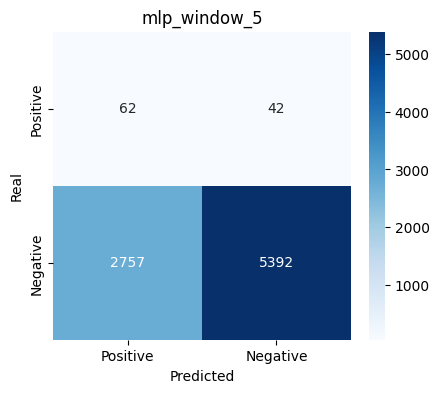

accuracy  : 66.09
precision : [99.23  2.2 ]
recall    : [66.17 59.62]
f1_score  : [79.39  4.24]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_6of10.h5


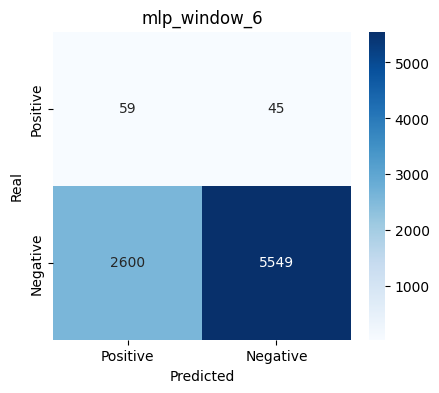

accuracy  : 67.95
precision : [99.2   2.22]
recall    : [68.09 56.73]
f1_score  : [80.75  4.27]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_7of10.h5


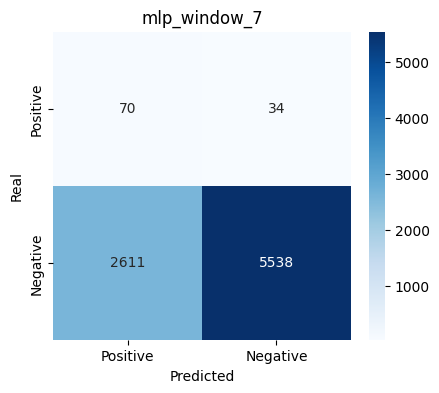

accuracy  : 67.95
precision : [99.39  2.61]
recall    : [67.96 67.31]
f1_score  : [80.72  5.03]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0765027322404372
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_8of10.h5


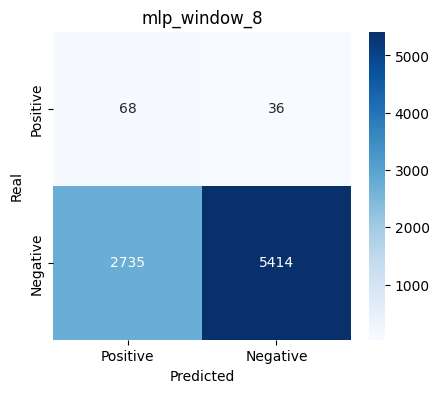

accuracy  : 66.42
precision : [99.34  2.43]
recall    : [66.44 65.38]
f1_score  : [79.62  4.68]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: -0.004077471967380227 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_9of10.h5


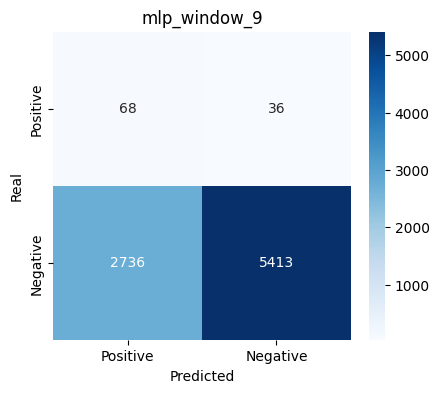

accuracy  : 66.41
precision : [99.34  2.43]
recall    : [66.43 65.38]
f1_score  : [79.61  4.68]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (33011, 87) (33011, 1)
check scale: 0.0 1.0

test: (8253, 87) (8253, 1)
check scale: 0.0 1.0
up-sampled train dataset: (65188, 87) (65188, 1)
MLP model has been restored from ./h5/mlp_window_5_100_cv_10of10.h5


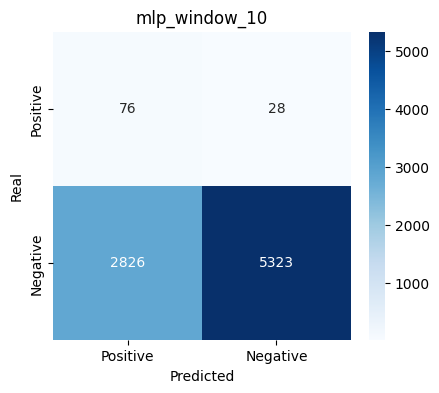

accuracy  : 65.42
precision : [99.48  2.62]
recall    : [65.32 73.08]
f1_score  : [78.86  5.06]


In [8]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])